In [26]:
%matplotlib widget

from graph_tool.all import Graph, graph_draw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import animation
from seaborn import heatmap, color_palette
from scipy import sparse

import nbimporter
from importlib import reload


# Utility Functions

In [2]:
def show_matrice(W):
    %matplotlib inline
    fig = plt.figure(figsize=(9,7))
    map = heatmap(W.todense(), cmap=color_palette("vlag", as_cmap=True))

In [3]:
def draw_heatmap_animation(history, temp, interval=1, file_to_save = None, fps = 10):
    if file_to_save == None: 
        %matplotlib notebook
    else:
        %matplotlib inline

    fig, ax = plt.subplots(figsize=(10, 4))

    def init():
        heatmap(history[0], cmap=color_palette("vlag", as_cmap=True))

    def animate(i):
        heatmap(history[i], cbar=False, cmap=color_palette("vlag", as_cmap=True))

    
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=temp, repeat = False, interval=1)
    if file_to_save != None: 
        writervideo = animation.FFMpegWriter(fps=fps)
        anim.save(file_to_save, writer=writervideo)
    else:
        return anim

In [28]:
from graph_tool.all import arf_layout,  value_types, get_hierarchy_tree, radial_tree_layout, get_hierarchy_control_points, minimize_nested_blockmodel_dl
import matplotlib
from math import sqrt

    def draw_network(W, Wout, Win):
    %matplotlib inline
    row, col= W.row, W.col
    W = W.toarray()/np.amax(W)
    n = len(Wout)
    
    # We add the edges
    edge_index = []
    pen_width = []
    for i in range(len(col)):
        edge_index.append((row[i], col[i]))
        pen_width.append(W[row[i]][col[i]])

    for i in range(len(Wout)):
        edge_index.append((i, n))
        pen_width.append(Wout[i]/np.amax(Wout))

    for i in range(len(Win)):
        edge_index.append((n+1, i))
        pen_width.append(Win[i]/np.amax(Win))

    edge_index = np.array(edge_index)
    g = Graph(directed=True)
    g.add_edge_list(edge_index)
    
    edge_pen_width  =  g.new_edge_property("double")
    edge_pen_width.a = np.abs(pen_width)*4

    vertex_color = []
    vertex_text = []
#     color = g.new_vp("double")
    text = g.new_vp("double")
    for v in g.vertex_index:
#         vertex_color.append(Win[v])
        vertex_text.append(v)
#     color.a = vertex_color
    text.a = vertex_text
    pos = arf_layout(g)
    pos[n] = [7, 4]
    pos[n+1] = [1, 4]
 
    # The curvatures of the edges
    state = minimize_nested_blockmodel_dl(g)
    t = get_hierarchy_tree(state)[0]
    tpos = radial_tree_layout(t, t.vertex(t.num_vertices() - 1), weighted=True)
    cts = get_hierarchy_control_points(g, t, tpos)

        
    graph_draw(g, pos=pos, output_size=(1000, 1000), edge_control_points=cts, 
               edge_pen_width = edge_pen_width, vertex_size=10, vertex_text = text,
               vcmap=matplotlib.cm.inferno)


# Reservoir functions

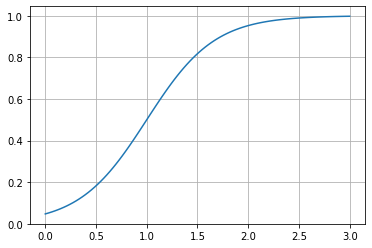

In [4]:
from importlib import reload
import reservoir.reservoir


from reservoir.reservoir import update_reservoir, ridge_regression, train, run
from reservoir.reservoir import init_matrices
from reservoir.reservoir import synaptic_scaling, activation_target_definition, constant_synaptic_scaling
from reservoir.activation_functions import tanh, heaviside, sigmoid

reload(reservoir.reservoir)

# SEED
SEED = 3789

# the activation function choosen for the rest of the experiment
%matplotlib inline

activation_function = lambda x : sigmoid(3*x-3)

plt.plot(np.linspace(0, 3, 100), activation_function(np.linspace(0, 3, 100)))
plt.grid()

# Measurement

## Richness in reservoir
https://arxiv.org/pdf/1903.05174.pdf

In [5]:
def uncoupled_dynamics(W, Win, bias, state, U_test1, leaky_rate = 1, temp = 5000, A= 0.9):
    ST = []
    if state is None:
        state = np.random.uniform(-1, 1, n)
        
    for i in range(temp):
        ST.append(state)
        u = U_test1[i]
        state = update_reservoir(W, Win, u, state, leaky_rate, bias, activation_function)

    ST = np.array(ST)

    _, S, _ = np.linalg.svd(ST)
    R = []
    for s in S:
        R.append(s / np.sum(S))

    UD = 0
    frac = 0
    while frac < A:
        frac = frac + R[UD]
        UD+=1
    return UD, frac

# Benchmark

## Random

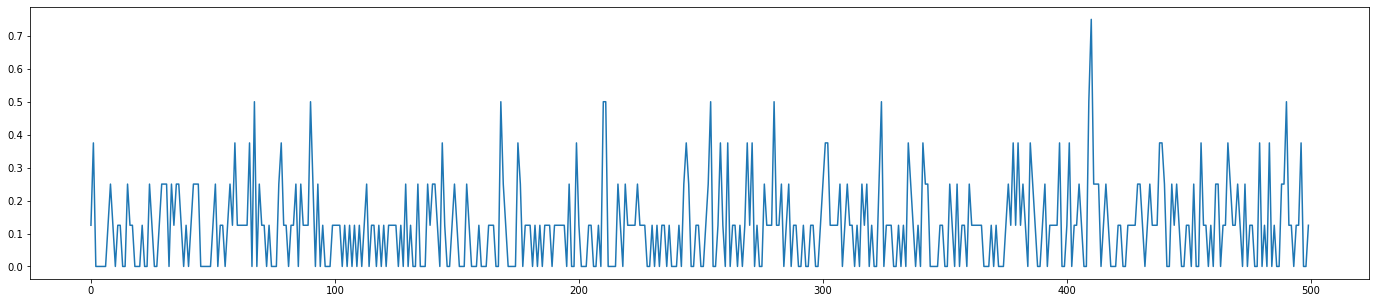

In [6]:
from scipy.stats import poisson

mu = 1
timesteps = 50000

U = poisson.rvs(mu, size=timesteps, random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
U_train1 = (U - U.min()) / (U.max() - U.min()) 

%matplotlib inline
plt.figure(figsize=(24,5))
plt.plot(range(500), U_train1[:500])
plt.show()

## Mackey glass

In [ ]:
from reservoirpy.datasets import mackey_glass

timesteps = 500000
tau = 17
U = mackey_glass(timesteps, tau=tau)

train_samples = 5000
test_length = 2000

# rescale between -1 and 1
U = 2 * (U - U.min()) / (U.max() - U.min()) - 1


from reservoirpy.datasets import to_forecasting

u, y = to_forecasting(U, forecast=10)
U_train1, y_train1 = u[:train_samples], y[:train_samples]
U_test1, y_test1 = u[train_samples:], y[train_samples:]

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(range(1000), U[:1000])
plt.show()

In [ ]:
U_train1.shape

## NARMA

In [ ]:
def createNARMA(length=10000, system_order=10, coef = [.3, .05, 1.5, .1]):

    inputs = np.random.rand(length, 1) * .5
    inputs.shape = (-1, 1)
    outputs = np.zeros((length, 1))
    for k in range(system_order - 1, length - 1):
        outputs[k + 1] = coef[0] * outputs[k] + coef[1] * \
                                           outputs[k] * np.sum(outputs[k - (system_order - 1):k + 1]) + \
                         coef[2] * inputs[k - (system_order-1)] * inputs[k] + coef[3]
    return inputs, outputs


def createNARMA10(length=10000):
    return createNARMA(length=length, system_order=10, coef=[.3, .05, 1.5, .1])


def createNARMA30(length=10000):
    return createNARMA(length=length, system_order=30, coef=[.2, .04, 1.5, .001])


In [ ]:
timesteps = 100000 
train_samples = 10000
test_lenght = 5000

u, y = createNARMA10(timesteps)

U_train1, y_train1 = u[:train_samples], y[:train_samples]
U_test1, y_test1 = u[train_samples:], y[train_samples:]

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(range(1000), U_train1[:1000])
plt.show()

# Hyperparameters search 

## Hyperopt

In [ ]:
import optuna
from losses import nrmse

def objective(trial):
    input_connectivity = trial.suggest_float('input_connectivity', 0.01, 0.99, step=0.005)
    connectivity = trial.suggest_float('connectivity', 0.01, 0.1, step=0.005)
    spectral_radius = trial.suggest_float('spectral_radius', 0.8, 3, step=0.05)
    bias_scaling = trial.suggest_float('bias_scaling', 0.4, 1.9, step=0.005)
    input_scaling = 1
    n = 50
    # Parameters
    leaky_rate = 1
    init_len = 200
    ridge_coef = 1e-8


    # Initialisation
    Win, W, bias =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
    bias = bias*bias_scaling
    best_nrmse_list = []
    best_ridge_coef_list = []

    # Training output
    Wout, b_out, last_state = train(W, Win, bias, U_train1, y_train1, activation_function, ridge_coef = ridge_coef, init_len=init_len, leaky_rate=leaky_rate)

    # Prediction
    y_pred1 = run(W, Win, bias, Wout, U_test1, activation_function, b_out, last_state, leaky_rate=leaky_rate)
    err = float(nrmse(y_test1, y_pred1))
    return err

study = optuna.create_study()
study.optimize(objective, n_trials=100, n_jobs=4)
study.best_params

## Gridsearch

In [ ]:
# Parameters
n = 300 # number of neurons
spectral_radius = 1.356
input_connectivity =  0.11
connectivity = 0.065
leaky_rate = 1
bias_scaling = 1.045
input_scaling = 2
init_len = 500

result = {"connectivity" : [], "input_connectivity" : [], "nrmse": []}

# Bias matrice
bias = np.random.binomial(size=n, n=1, p= 0.5)
bias = bias*bias_scaling
    
for i in range(10):
    connectivity = (i + 1)/10

    # Reservoir matrice
    W = sparse.random(n, n, density=connectivity, random_state=SEED, data_rvs=stats.norm().rvs)

    # Set the spectral radius
    eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol = 0.1, return_eigenvectors=False)
    sr = max(abs(eigen))
    W *= spectral_radius/sr
    
    for j in range(100): 
        input_connectivity = (j + 1)/100
        
        # Input matrice
        Win = sparse.random(n, 1, density=input_connectivity, random_state=SEED,  data_rvs=stats.norm().rvs)
        Win = input_scaling*Win
        
        # Training output
        Wout, b_out, last_state = train(W, Win, bias, U_train1, y_train1, ridge_coef = 1e-2, init_len=init_len, leaky_rate=leaky_rate)

        # Prediction
        y_pred1 = run(W, Win, bias, Wout, U_test1, b_out, last_state, leaky_rate=leaky_rate)
        nrmse_value = float(nrmse(y_test1, y_pred1))
        result['connectivity'].append(connectivity)
        result['input_connectivity'].append(input_connectivity)
        result['nrmse'].append(nrmse_value)
        
result

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm

X = np.array(result['connectivity']).reshape((100,100))
Y = np.array(result['input_connectivity']).reshape((100,100))
Z = np.array(result['nrmse']).reshape((100,100))
X, Y, Z

%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z,  cmap=cm.coolwarm)

## Ridge search throughout cross validation

https://arxiv.org/pdf/1908.08450.pdf

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
# k -fold walk forward validation
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [ ]:
# Parameters
n = 10 # number of neurons

spectral_radius = 1.45
input_connectivity =  0.745
connectivity = 0.075
SEED = 304
leaky_rate = 1
bias_scaling = 0.485
input_scaling = 1
init_len = 200


# Initialisation
Win, W, bias =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
bias = bias*bias_scaling

# Synaptic scaling to a given target
Ws = synaptic_scaling(W)

best_nrmse_list = []
best_ridge_coef_list = []

# Index spliting
tscv = BlockingTimeSeriesSplit(n_splits=4)
for train_index, test_index in tscv.split(U_train1):
    print("TRAIN:", train_index[0], train_index[-1], "TEST:", test_index[0], test_index[-1]) 
    U_train, U_val = U_train1[train_index], U_train1[test_index]
    y_train, y_val = y_train1[train_index], y_train1[test_index]
    
    best_nrmse = 2
    
    for ridge_coef in np.logspace(-10, 0,  num=11):
        
        # Training output
        Wout, b_out, last_state = train(W, Win, bias, U_train, y_train, ridge_coef = ridge_coef, init_len=init_len, leaky_rate=leaky_rate)

        # Prediction
        y_val_pred = run(W, Win, bias, Wout, U_val, b_out, last_state, leaky_rate=leaky_rate)
        temp_nrmse  = float(nrmse(y_val_pred, y_val))
        if temp_nrmse < best_nrmse : 
            best_nrmse = temp_nrmse
            best_ridge_coef = ridge_coef
            
    best_nrmse_list.append(best_nrmse)
    best_ridge_coef_list.append(best_ridge_coef)
    
min_val_idx = [i for i in range(len(best_nrmse_list)) if best_nrmse_list[i]==min(best_nrmse_list)][0]

print(best_ridge_coef_list[min_val_idx])

# Synaptic Plasticity

## Influence of synapic scaling on efficiency

In [ ]:
from losses import nrmse

# Parameters
n = 50 # number of neurons

spectral_radius = 1.45
input_connectivity =  0.745
connectivity = 0.075
leaky_rate = 1
input_scaling = 1
SEED = 304
bias_scaling = 0.485
init_len = 200

data = {
"ridge" : [],
"error" : [],
"with_synaptic_scaling" : [],
"UC_values" : [],
"frac_values": []
}
for ridge_coef in np.logspace(-10, 0, 11):
    # Initialisation
    Win, W, bias =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
    bias = bias*bias_scaling
    Win = Win*input_scaling
    
    # Training output
    Wout, b_out, last_state = train(W, Win, bias, U_train1, y_train1, ridge_coef = ridge_coef, init_len=init_len, leaky_rate=leaky_rate)
    # Prediction
    y_pred1 = run(W, Win, bias, Wout, U_test1[:test_length], b_out, last_state, leaky_rate=leaky_rate)
    data["ridge"].append(ridge_coef)
    data["error"].append(float(nrmse(y_test1[:test_length], y_pred1)))
    data["with_synaptic_scaling"].append(False)
    UD, frac = uncoupled_dynamics(W, Win, bias, None, U_test1, leaky_rate, temp = 1000,A =0.9)
    data["UC_values"].append(UD)
    data["frac_values"].append(frac)
    
    # Synaptic scaling to a given target
    Ws = synaptic_scaling(W)
    # Training output
    Wout, b_out, last_state = train(Ws, Win, bias, U_train1, y_train1, ridge_coef = ridge_coef, init_len=init_len, leaky_rate=leaky_rate)
    # Prediction
    y_pred1 = run(Ws, Win, bias, Wout, U_test1[:test_length], b_out, last_state, leaky_rate=leaky_rate)
    data["ridge"].append(ridge_coef)
    data["error"].append(float(nrmse(y_test1[:test_length], y_pred1)))
    data["with_synaptic_scaling"].append(True)
    UD, frac = uncoupled_dynamics(Ws, Win, bias, None, U_test1, leaky_rate, temp = 1000,A =0.9)
    data["UC_values"].append(UD)
    data["frac_values"].append(frac)

data2 = {
"connectivity" : [],
"error" : [],
"with_synaptic_scaling" : [],
"UC_values" : [],
"frac_values": []
}

ridge_coef = 1e-4
for connectivity in np.linspace(0.01, 0.2, 20):
    # Initialisation
    Win, W, bias =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
    bias = bias*bias_scaling
    Win = Win*input_scaling
    
    # Training output
    Wout, b_out, last_state = train(W, Win, bias, U_train1, y_train1, ridge_coef = ridge_coef, init_len=init_len, leaky_rate=leaky_rate)
    # Prediction
    y_pred1 = run(W, Win, bias, Wout, U_test1[:test_length], b_out, last_state, leaky_rate=leaky_rate)
    data2["connectivity"].append(connectivity)
    data2["error"].append(float(nrmse(y_test1[:test_length], y_pred1)))
    data2["with_synaptic_scaling"].append(False)
    UD, frac = uncoupled_dynamics(W, Win, bias, None, U_test1, leaky_rate, temp = 1000,A =0.9)
    data2["UC_values"].append(UD)
    data2["frac_values"].append(frac)
    
    # Synaptic scaling to a given target
    Ws = synaptic_scaling(W)
    # Training output
    Wout, b_out, last_state = train(Ws, Win, bias, U_train1, y_train1, ridge_coef = ridge_coef, init_len=init_len, leaky_rate=leaky_rate)
    # Prediction
    y_pred1 = run(Ws, Win, bias, Wout, U_test1[:test_length], b_out, last_state, leaky_rate=leaky_rate)
    data2["connectivity"].append(connectivity)
    data2["error"].append(float(nrmse(y_test1[:test_length], y_pred1)))
    data2["with_synaptic_scaling"].append(True)
    UD, frac = uncoupled_dynamics(Ws, Win, bias, None, U_test1, leaky_rate, temp = 1000,A =0.9)
    data2["UC_values"].append(UD)
    data2["frac_values"].append(frac)


In [ ]:
data2 = pd.DataFrame.from_dict(data2)
data = pd.DataFrame.from_dict(data)

In [ ]:
%matplotlib inline

fig, axes = plt.subplots(3, 2, figsize= (14, 8), sharex="col", sharey="row")

# ---- Column 1 -----#
scatter = axes[0, 0].scatter(x=data["ridge"], y=data["error"], c=data["with_synaptic_scaling"])
axes[0, 0].set(ylabel="error")
axes[0, 0].legend(handles=scatter.legend_elements()[0], labels=["without scaling", "with scaling"])

axes[1, 0].scatter(data=data, x="ridge", y="UC_values", c="with_synaptic_scaling")
axes[1, 0].set(ylabel="UC")

axes[2, 0].scatter(data=data, x="ridge", y="frac_values", c="with_synaptic_scaling")
axes[2, 0].set(xlabel="Ridge", ylabel="frac")
axes[2,0].set_xscale('log')


# ---- Column 2 -----#
axes[0, 1].scatter(x=data2["connectivity"], y=data2["error"], c=data2["with_synaptic_scaling"])

axes[1, 1].scatter(data=data2, x="connectivity", y="UC_values", c="with_synaptic_scaling")

axes[2, 1].scatter(data=data2, x="connectivity", y="frac_values", c="with_synaptic_scaling")
axes[2, 1].set(xlabel="connectivity")


## Initial analysis of synaptic plasticity

In [ ]:
# Parameters
n = 50 # number of neurons

spectral_radius = 1.45
input_connectivity =  0.745
connectivity = 0.075
SEED = 304
leaky_rate = 1
bias_scaling = 0.6
input_scaling = 1
init_len = 200

ridge_coef = 1e-4

# Initialisation
Win, W, bias =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
bias = bias*bias_scaling
Win = Win*input_scaling

Generate the matrix with synaptic scaling

##### Spectral radius, uncoupled dynamics and connection matrix

In [ ]:
# Spectral radius
eigen_values, eigen_vectors = sparse.linalg.eigs(W, k=10, which="LM", maxiter=W.shape[0] * 20, tol = 0.1)
sr = max(abs(eigen_values))
print("spectral radius", sr)

# Uncoupled dynamics
UD, frac = uncoupled_dynamics(W, Win, bias, None, U_test1, leaky_rate, temp = 1000,A =0.9)
print("UD", UD, "for", frac)

%matplotlib inline
show_matrice(W)

##### Delta activity visualisation

In [ ]:
U_test3, y_test3 = U_test1, y_test1

# Parameters
target_activation_levels = np.ones(n)*0.5
minimum_calcium_concentration = np.ones(n)*0.05
growth_parameter = 1

state = np.random.uniform(0, 1, n)
delta_z_history = []
temp = 50
increment = 20
for t in range(temp):
    delta_z_history.append(compute_synaptic_change(state, target_activation_levels, growth_parameter, "linear", minimum_calcium_concentration).reshape(5,10))
    for i in range(increment):
        state = update_reservoir(W, Win, U_test3[0], state, leaky_rate, bias)
    U_test3, y_test3 = U_test3[increment:], y_test3[increment:]

# draw_heatmap_animation(delta_z_history, temp, interval=5, file_to_save="deltaz_without_ss.mp4", fps=10)
draw_heatmap_animation(delta_z_history, temp, interval=5)


##### Spectral radius, uncoupled dynamics and connection matrix after synaptic scaling

In [ ]:
# Spectral radius
sr = max(abs(sparse.linalg.eigs(Ws, k=1, which="LM", maxiter=Ws.shape[0] * 20, tol = 0.1, return_eigenvectors=False)))
print("spectral radius", sr)

# Uncoupled dynamics
UD, frac = uncoupled_dynamics(Ws, Win, bias, None, U_test1, leaky_rate, temp = 1000,A =0.9)
print("UD", UD, "for", frac)

show_matrice(Ws)

##### Delta activity visualisation

In [ ]:
U_test3, y_test3 = U_test1, y_test1

# Parameters
target_activation_levels = np.ones(n)*0.5
minimum_calcium_concentration = np.ones(n)*0.05
growth_parameter = 1

state = np.random.uniform(0, 1, n)
delta_z_history = []
temp = 50
for t in range(temp):
    delta_z_history.append(compute_synaptic_change(state, target_activation_levels, growth_parameter, "linear", minimum_calcium_concentration).reshape(5,10))
    for i in range(increment):
        state = update_reservoir(Ws, Win, U_test3[0], state, leaky_rate, bias)
    U_test3, y_test3 = U_test3[increment:], y_test3[increment:]

# draw_heatmap_animation(delta_z_history, temp, interval=1, file_to_save="deltaz_with_ss.mp4", fps=10)
draw_heatmap_animation(delta_z_history, temp, interval=1)

# Training and visualisation

## Matrice initialisation

In [ ]:
# Parameters
n = 50 # number of neurons

spectral_radius = 0.73
input_connectivity =  0.745
connectivity = 0.07
leaky_rate = 1
bias_scaling = 0.405
input_scaling = 1
init_len = 200

ridge_coef = 1e-4

# Initialisation
Win, W, bias =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
bias = bias*bias_scaling
Win = Win*input_scaling

## Training

In [ ]:
# Training output
Wout, b_out, last_state = train(W, Win, bias, U_train1, y_train1, activation_function, ridge_coef = ridge_coef, init_len=init_len, leaky_rate=leaky_rate)

In [ ]:
# Prediction
y_pred1 = run(W, Win, bias, Wout, U_test1[:test_length], activation_function, b_out, last_state, leaky_rate=leaky_rate)

## Visualisation

In [ ]:
from reservoirpy_util import plot_results, plot_readout
from losses import nrmse
%matplotlib inline

sample = 200
plot_readout(Wout)
plot_results(y_pred1, y_test1, sample=sample)
print("nrmse", float(nrmse(y_test1[0:test_length], y_pred1)))
plot_readout(Win.T.toarray(), "Win")

##### Draw nice connection graph

##### other plots

In [ ]:
%matplotlib inline

plt.plot(np.linspace(-1, 1, 10), activation_function(np.linspace(-1, 1, 10)))
plt.grid()

In [ ]:
state_history = []
state = last_state

state_history.append(state.reshape(5,10))

temp = 200
for i in range(temp - 1):
    u = U_test1[i]
    state = update_reservoir(W, Win, u, state, leaky_rate, bias, activation_function)
    state_history.append(state.reshape(5,10))
    
draw_heatmap_animation(state_history, temp, interval=1)


In [ ]:
UD, frac = uncoupled_dynamics(W, Win, bias, state, U_test1, leaky_rate, temp = 1000,A =0.9)
print("UD", UD, "for", frac)

# Spectral radius
sr = max(abs(sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol = 0.1, return_eigenvectors=False)))
print("spectral radius", sr)

In [ ]:
%matplotlib inline

from math import copysign

plt.figure(figsize=(18, 6))
random_neurons_indices =  np.sort(np.random.randint(n, size=19)) #Size max is 19 because there is not enough colors
# non_zeros_indices = np.flatnonzero(Wout)[:19]
colors = color_palette("tab20")

neurons_evolution = np.array(state_history).reshape(temp, n)
x =range(temp)
j = 0
for i in random_neurons_indices:
    plt.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    plt.plot(0, neurons_evolution[0, i], marker='o', color=colors[j], markersize=Wout[0][i]/np.amax(Wout)*50, alpha=0.5)
    plt.text(-3, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1

# plt.plot(np.arange(0, temp), y_pred1[-temp:], label="Training objective", color=colors[-1])

plt.legend(fontsize=16, loc="right")

# Add random connexion

In [ ]:
from connexion_generation.utility import compare

In [ ]:
from connexion_generation.random_connexion import add_random_connexion

In [ ]:
W_with_random = W.copy()
U_test3, y_test3 = U_test1, y_test1

# Training output
Wout, b_out, last_state = train(W_with_random, Win, bias, U_train1, y_train1, activation_function, 
                                ridge_coef = ridge_coef, init_len=init_len, leaky_rate=leaky_rate)

low = 0
high= 1

y_pred = run(W_with_random, Win, bias, Wout, U_test1[:test_length], activation_function, b_out, last_state, leaky_rate=leaky_rate)

nrmse_base = nrmse(y_test1[:test_length], y_pred)
print(float(nrmse_base))

unsuccesul_addition = 0
increment = 20
state = last_state
for i in range(100):

    W_new = add_random_connexion(W_with_random, low, high)
    W_new = synaptic_scaling(W_new)   
    W_with_random, success = compare(W_with_random, W_new, Win, bias, Wout, activation_function, b_out, U_test3[:test_length], y_test3[:test_length], last_state, leaky_rate)
    unsuccesul_addition += success
    
    for i in range(increment):
        state = update_reservoir(W_with_random, Win, U_test3[0], state, leaky_rate, bias, activation_function)
    U_test3, y_test3 = U_test3[increment:], y_test3[increment:]
        

y_pred_new = run(W_with_random, Win, bias, Wout, U_test1[:test_length], activation_function, b_out, last_state)
print("nrmse", float(nrmse(y_test1[:test_length], y_pred_new)))
print("Unsuccessful addition : ", unsuccesul_addition)

#### Pourcentage of unsuccess

In [ ]:
print("failure :", unsuccesul_addition, "%")

# Activity dependant connexion
https://www.nature.com/articles/s41598-018-22077-3#Fig1

In [8]:
from importlib import reload
from connexion_generation.activity_dependant_connexion import add_good_activity_connexion, add_activity_connexion, compute_synaptic_change
from connexion_generation.activity_dependant_connexion import select_pairs_connexion, select_pairs_pruning, change_connexion
import connexion_generation.activity_dependant_connexion
reload(connexion_generation.activity_dependant_connexion)

<module 'connexion_generation.activity_dependant_connexion' from '/home/idlab278/Code/artificial_embryogenesis/connexion_generation/activity_dependant_connexion.py'>

## Hyperopt optimisation

In [ ]:
import optuna
from losses import nrmse

# Parameters
n = 50 # number of neurons

spectral_radius = 1.45
input_connectivity =  0.745
connectivity = 0.075
SEED = 3789
leaky_rate = 1
bias_scaling = 0.6
input_scaling = 1
init_len = 200

ridge_coef = 1e-4

# Initialisation
Win, W, bias =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
bias = bias*bias_scaling
Win = Win*input_scaling

# Training output
Wout, b_out, last_state = train(W, Win, bias, U_train1, y_train1, activation_function, ridge_coef = ridge_coef, init_len=init_len, leaky_rate=leaky_rate)

def objective(trial):
    target_activation_levels = trial.suggest_float('target_activation_levels', 0.1, 1)
    growth_parameter = trial.suggest_float('growth_parameter', 0, 0.2)
    low = trial.suggest_float('low', 0.05, 0.5)
    high = trial.suggest_float('high', low, 1)

    W_with_activity = W.copy()
    U_test3, y_test3 = U_test1, y_test1

    total_add = 0
    total_prun = 0
    fail_add = 0
    fail_prun = 0
    total = 0
    
    increment = 20
    state = last_state
    length = len(U_test3)
    while total< 100 and length > 5000:
        W_with_activity,  bad_add, bad_prun, tried_add, tried_prun = add_good_activity_connexion(W_with_activity, Win, bias,
                                    Wout, activation_function,  b_out, state, U_test3[:test_length], y_test3[:test_length], target_activation_levels, growth_parameter, 
                                                "linear", low, high)
        for i in range(increment):
            state = update_reservoir(W_with_activity, Win, U_test3[0], state, leaky_rate, bias, activation_function)
        U_test3, y_test3 = U_test3[increment:], y_test3[increment:]

        total_add += tried_add
        total_prun += tried_prun
        fail_add +=bad_add
        fail_prun +=bad_prun
        total += tried_add + tried_prun
        length = len(U_test3)

    if total > 0: 
        err = (fail_add+fail_prun)/total
        print(fail_add, fail_prun, total, err)
    else: 
        err = 1
        print(fail_add, fail_prun, total, err)
    return err


study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100, n_jobs=8) 

study.best_params

In [ ]:
from optuna.visualization.matplotlib import plot_param_importances, plot_contour, plot_parallel_coordinate, plot_slice

%matplotlib inline

plot_param_importances(study)
plot_contour(study)
plot_parallel_coordinate(study)
plot_slice(study)

## Efficiency measurement

In [ ]:
from losses import nrmse

# Parameters
n = 50 # number of neurons

spectral_radius = 1.45
input_connectivity =  0.745
connectivity = 0.075
SEED = 3789
leaky_rate = 1
bias_scaling = 0.6
input_scaling = 1
init_len = 200
activation_function = sigmoid

ridge_coef = 1e-4

# Initialisation
Win, W, bias =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
bias = bias*bias_scaling
Win = Win*input_scaling

# Training output
Wout, b_out, last_state = train(W, Win, bias, U_train1, y_train1, activation_function, ridge_coef = ridge_coef, init_len=init_len, leaky_rate=leaky_rate)

# Initialisation
W_with_activity = W.copy()

U_test3, y_test3 = U_test1, y_test1

# Parameters
minimum_calcium_concentration = 0.05

target_activation_levels = np.ones(n)*0.8190311034525687
growth_parameter = 1.3897059875417863
low = 0.48397251349230114
high= 0.7829665697649346

total_add = 0
total_prun = 0
fail_add = 0
fail_prun = 0
total = 0
increment = 20

state = last_state
delta_z_history = []
while total< 100:
    delta_z_history.append(compute_synaptic_change(state, target_activation_levels, growth_parameter, "linear", minimum_calcium_concentration).reshape(5,10))
    
    W_with_activity,  bad_add, bad_prun, tried_add, tried_prun = add_good_activity_connexion(W_with_activity, Win, bias, Wout, activation_function, b_out,
                                    state, U_test3[:test_length], y_test3[:test_length], target_activation_levels, growth_parameter, 
                                                 "linear", low, high, minimum_calcium_concentration)
    
#     W_with_activity, connexion_tried, pruning_tried = add_activity_connexion(W_with_activity, Win, bias, Wout, b_out,
#                                     state, U_test3[:test_length], y_test3[:test_length], target_activation_levels, growth_parameter, 
#                                                 "linear", minimum_calcium_concentration, low, high)
    for i in range(increment):
        state = update_reservoir(W_with_activity, Win, U_test3[0], state, leaky_rate, bias, activation_function)
    U_test3, y_test3 = U_test3[increment:], y_test3[increment:]
    
    total_add += tried_add
    total_prun += tried_prun
    fail_add +=bad_add
    fail_prun +=bad_prun
    total += tried_add + tried_prun
#     print(total)

In [ ]:
print("total connexion :", total_add)
print("total failed :", fail_add)
print("failure :", round(fail_add/total_add*100), "%")

%matplotlib inline
# Here don't forget to put the last state
y_pred_new = run(W_with_activity, Win, bias, Wout, U_test1[:2000], b_out, last_state, leaky_rate)    

plot_results(y_pred_new, y_test1[:2000], sample=sample)
print("nrmse", float(nrmse(y_test1[:2000], y_pred_new)))

## Simulation

In [9]:
def count_incoming_connexions(W):
    incoming_connexion = W.nonzero()[0]
    incoming_connexion_count = np.zeros(W.shape[0])
    for i in incoming_connexion:
        incoming_connexion_count[i] +=1
    return incoming_connexion_count

In [29]:
# Parameters
n = 50 # number of neurons
SEED = 3789
leaky_rate = 1
input_scaling = 1

spectral_radius = 1.45
input_connectivity =  0.745
connectivity = 0.075

# HPERPARAMETERS
INCREMENT = 20
VALUE = 0.1
bias_scaling = 0.2


# Initialisation
Win, W, bias =  init_matrices(n, input_connectivity, connectivity, spectral_radius, input_scaling, SEED)
bias = bias*bias_scaling
Win = Win*input_scaling

# last_state
last_state = np.random.uniform(0, 1, n)

In [30]:
from importlib import reload
from connexion_generation.activity_dependant_connexion import select_pairs_connexion, select_pairs_pruning, change_connexion
import connexion_generation.activity_dependant_connexion
reload(connexion_generation.activity_dependant_connexion)


final_connectivity = []
state_history =  []
results = {"target_activation_levels" : [] , "growth_parameter": [], "final_connectivity" : [], "convergence_step":[]}
for growth_parameter in np.logspace(-2, -0.1, 5):
    final_connectivity_by_level = []
    for target_activation_levels in np.linspace(0.05, 0.95, 10):
        # Initialisation
        W_with_activity = W.copy()
        U_train3 = U_train1
        state = last_state
        length = len(U_train3)
        step=0
        total_add = 0
        total_prun = 0
        
        # Watched variables
        convergence_step = 0
        add = []
        prun = []
        incoming_connexion_count_history = []
        delta_z_history = []
        connectivity = []

        while total_add + total_prun< 3000 and length > 5000:

            incoming_connexion_count_history.append(count_incoming_connexions(W_with_activity))
            delta_z = compute_synaptic_change(state, target_activation_levels, growth_parameter, "linear")
            
            W_with_activity, nb_new_add, nb_new_prun = add_activity_connexion(W_with_activity, state, delta_z, VALUE)

            for i in range(INCREMENT):
                state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
                state_history.append(state)
            U_train3 = U_train3[INCREMENT:]

            length = len(U_train3)
            total_add += nb_new_add
            total_prun += nb_new_prun
            add.append(total_add)
            prun.append(total_prun)
            if step > 5 and convergence_step == 0:
                mean_add = (add[-1]-add[-5])/2
                mean_prun = (prun[-1]-prun[-5])/2
                if prun[3] > add[3] and mean_add >= mean_prun: 
                    convergence_step = step
                if prun[3] < add[3] and mean_add <= mean_prun: 
                    convergence_step = step
            step +=1

        results["final_connectivity"].append(W_with_activity.count_nonzero()/n**2)
        results["convergence_step"].append(convergence_step)
        results["target_activation_levels"].append(target_activation_levels)
        results["growth_parameter"].append(growth_parameter)

In [31]:
df = pd.DataFrame.from_dict(results)

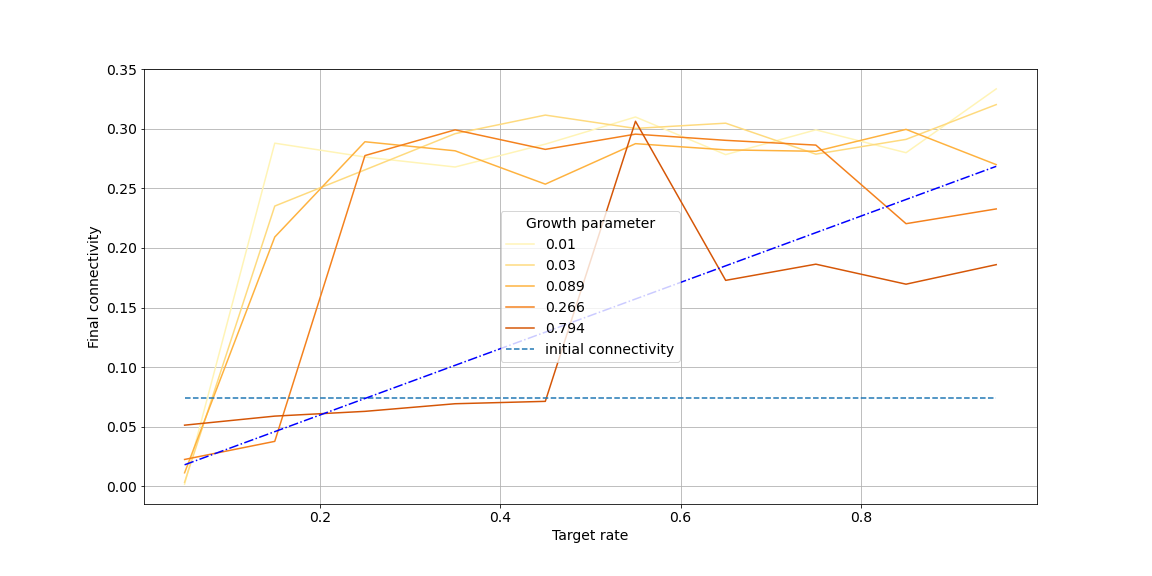

In [32]:
MEDIUM_SIZE = 14
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes

fig, ax = plt.subplots(figsize=(16,8))
color_map = color_palette("YlOrBr", n_colors=6)

i = 0
for key, grp in df.groupby(['growth_parameter']):
    ax.plot(grp['target_activation_levels'], grp['final_connectivity'], label=round(key*1000)/1000, c = color_map[i])
    i += 1
ax.plot(np.linspace(0.05, 0.95, 10), [W.count_nonzero()/n**2]*10, linestyle = "--", label="initial connectivity")

mean_low = df.loc[df["target_activation_levels"]  == 0.05]["final_connectivity"].mean()
mean_high = df.loc[df["target_activation_levels"]  == 0.95]["final_connectivity"].mean()
ax.plot([0.05, 0.95], [mean_low, mean_high],linestyle = "-.", c = "b")

ax.legend( title="Growth parameter")
ax.set_xlabel('Target rate')
ax.set_ylabel('Final connectivity')
ax.grid(True)

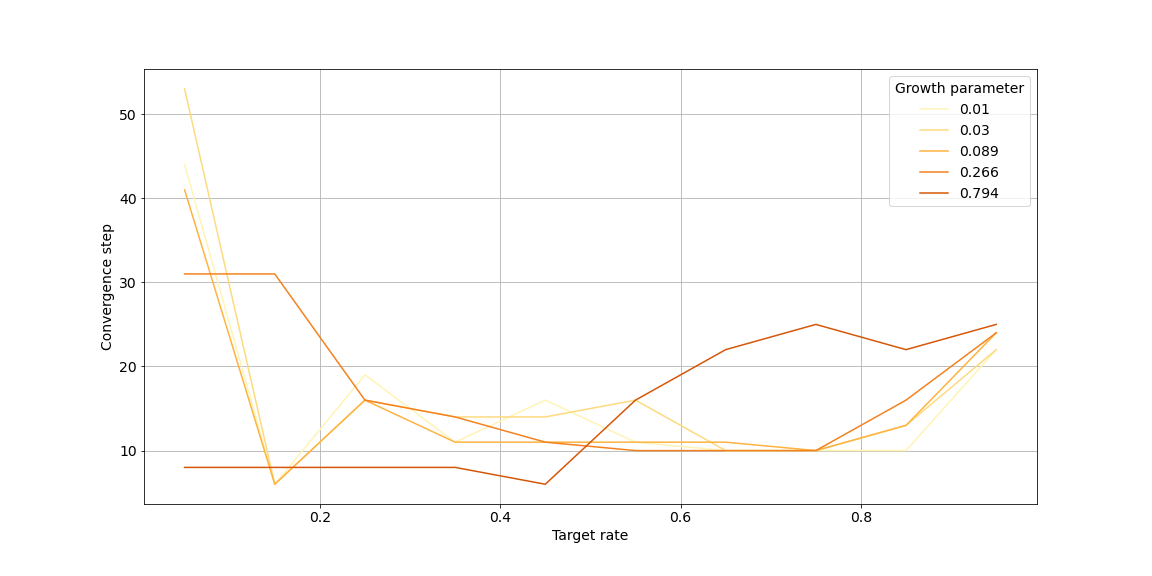

In [33]:
MEDIUM_SIZE = 14
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes

color_map = color_palette("YlOrBr", n_colors=6)

i = 0
fig, ax = plt.subplots(figsize=(16,8))
for key, grp in df.groupby(['growth_parameter']):
    ax.plot(grp['target_activation_levels'], grp['convergence_step'], label=round(key*1000)/1000, c = color_map[i])
    i += 1
    
ax.legend( title="Growth parameter")
ax.set_xlabel('Target rate')
ax.set_ylabel('Convergence step')
ax.grid(True)

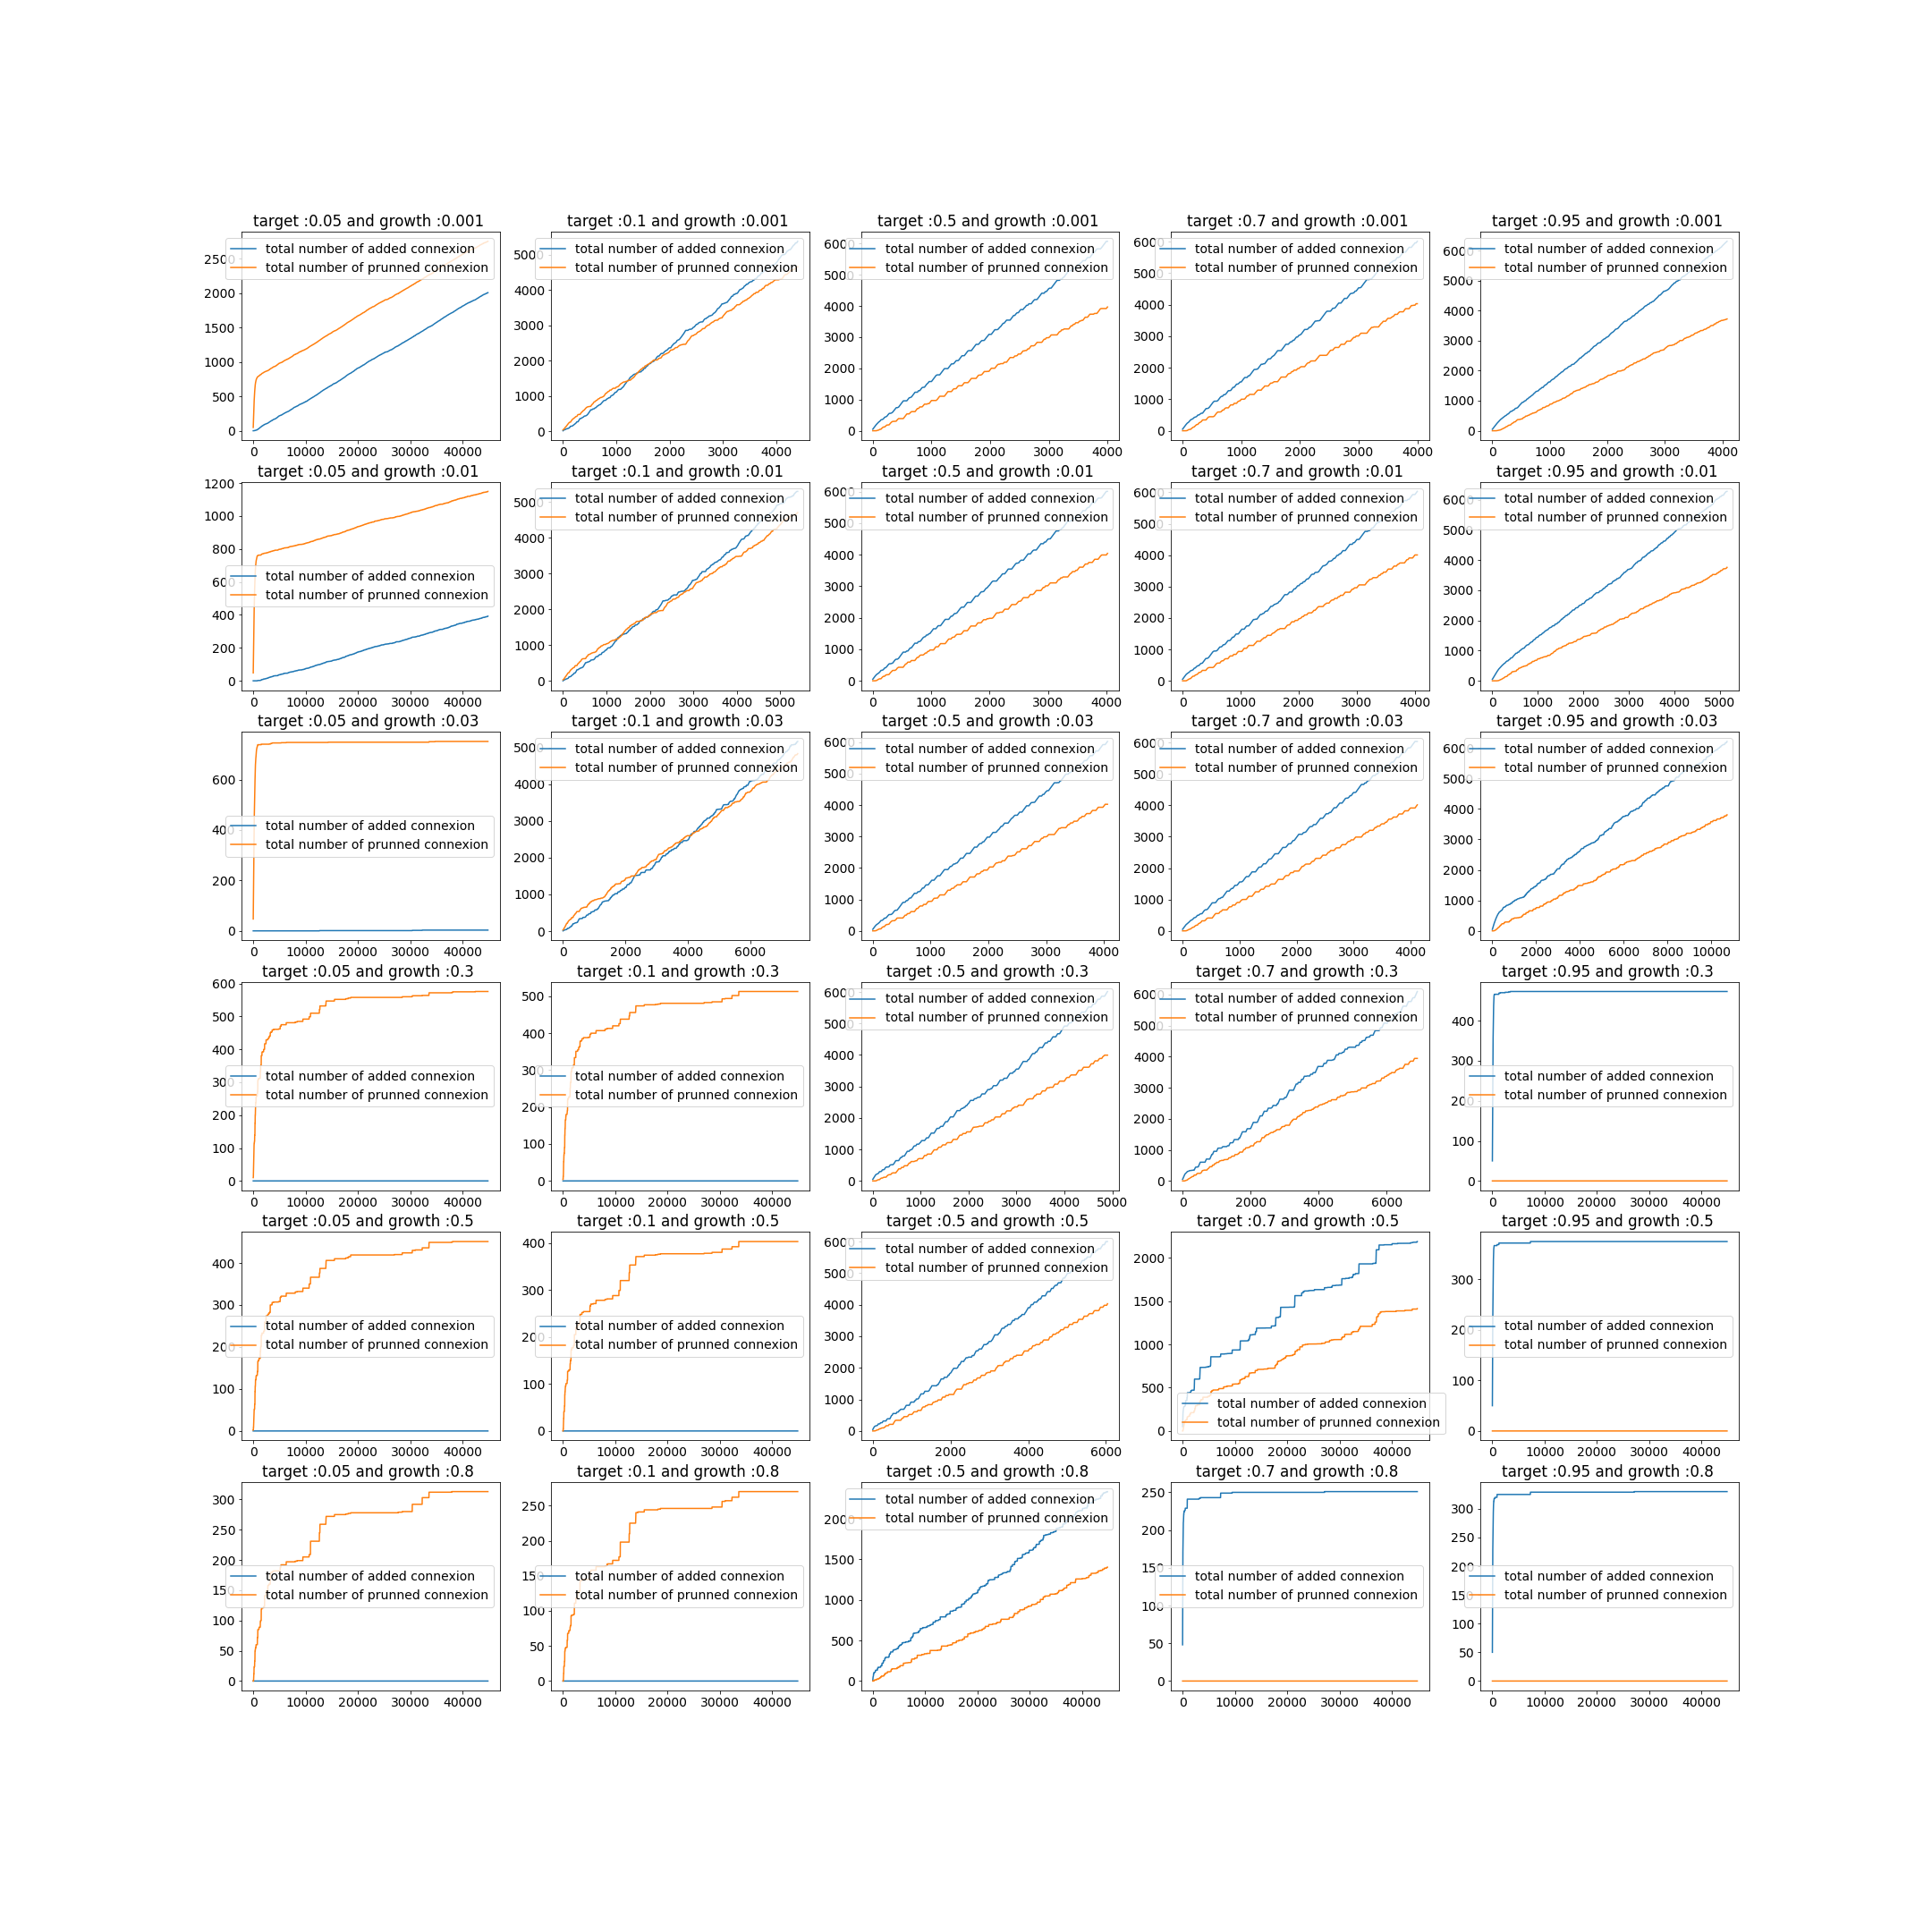

In [34]:
# Parameters
minimum_calcium_concentration = np.ones(n)*0.1

# The parameters you want to see the influence
fig, ax = plt.subplots(6, 5, figsize=(30,30))
k = 0
for growth_parameter in [0.001, 0.01, 0.03, 0.3, 0.5, 0.8]:
    j = 0
    for target_activation_levels in [0.05, 0.1, 0.5, 0.7, 0.95]:

        # Initialisation
        W_with_activity = W.copy()
        U_train3 = U_train1
        state = last_state
        length = len(U_train3)
        step=0
        convergence_step = 0

        total_add = 0
        total_prun = 0
        add = []
        prun = []
        mean_prun = []

        incoming_connexion_count_history = []
        state_history = []
        delta_z_history = []

        for i in range(INCREMENT*5):
            state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
            state_history.append(state)
        U_train3 = U_train3[INCREMENT*5:]
        
        while total_add + total_prun < 10000 and length > 5000:

            incoming_connexion_count_history.append(count_incoming_connexions(W_with_activity))
            delta_z = compute_synaptic_change(state, target_activation_levels, growth_parameter, "linear", minimum_calcium_concentration)
            delta_z_history.append(delta_z)

            W_with_activity, nb_new_add, nb_new_prun = add_activity_connexion(W_with_activity, state, delta_z, VALUE)

            for i in range(INCREMENT):
                state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
                state_history.append(state)
            U_train3 = U_train3[INCREMENT:]

            length = len(U_train3)
            total_add += nb_new_add
            total_prun += nb_new_prun
            add.append(total_add)
            prun.append(total_prun)
            if step > 5 and convergence_step == 0:
                mean_add = (add[-1]-add[-5])/2
                mean_prun = (prun[-1]-prun[-5])/2
                if prun[3] > add[3] and mean_add >= mean_prun: 
                    convergence_step = step
                if prun[3] < add[3] and mean_add <= mean_prun: 
                    convergence_step = step
            step +=1
        ax[k][j].plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
        ax[k][j].plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
        ax[k][j].title.set_text(f'target :{target_activation_levels} and growth :{growth_parameter} ')
        ax[k][j].legend()
        j+=1    
    k+= 1


### Visualisation of one evolution 

#### first set of parameters

In [35]:
# Parameters
minimum_calcium_concentration = np.ones(n)*0.1

# The parameters you want to see the influence

growth_parameter = 0.5
target_activation_levels=0.7

# Initialisation
W_with_activity = W.copy()
U_train3 = U_train1
state = last_state
length = len(U_train3)
step=0
convergence_step = 0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

incoming_connexion_count_history = []
state_history = []
delta_z_history = []

for i in range(INCREMENT*5):
    state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
    state_history.append(state)
U_train3 = U_train3[INCREMENT:]

while total_add + total_prun < 20000 and length > 5000:

    incoming_connexion_count_history.append(count_incoming_connexions(W_with_activity))
    delta_z = compute_synaptic_change(state, target_activation_levels, growth_parameter, "linear", minimum_calcium_concentration)
    delta_z_history.append(delta_z)

    W_with_activity, nb_new_add, nb_new_prun = add_activity_connexion(W_with_activity, state, delta_z, VALUE)

    for i in range(INCREMENT):
        state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
        state_history.append(state)
    U_train3 = U_train3[INCREMENT:]
    
    length = len(U_train3)
    total_add += nb_new_add
    total_prun += nb_new_prun
    add.append(total_add)
    prun.append(total_prun)
    if step > 5 and convergence_step == 0:
        mean_add = (add[-1]-add[-5])/2
        mean_prun = (prun[-1]-prun[-5])/2
        if prun[3] > add[3] and mean_add >= mean_prun: 
            convergence_step = step
        if prun[3] < add[3] and mean_add <= mean_prun: 
            convergence_step = step
    step +=1

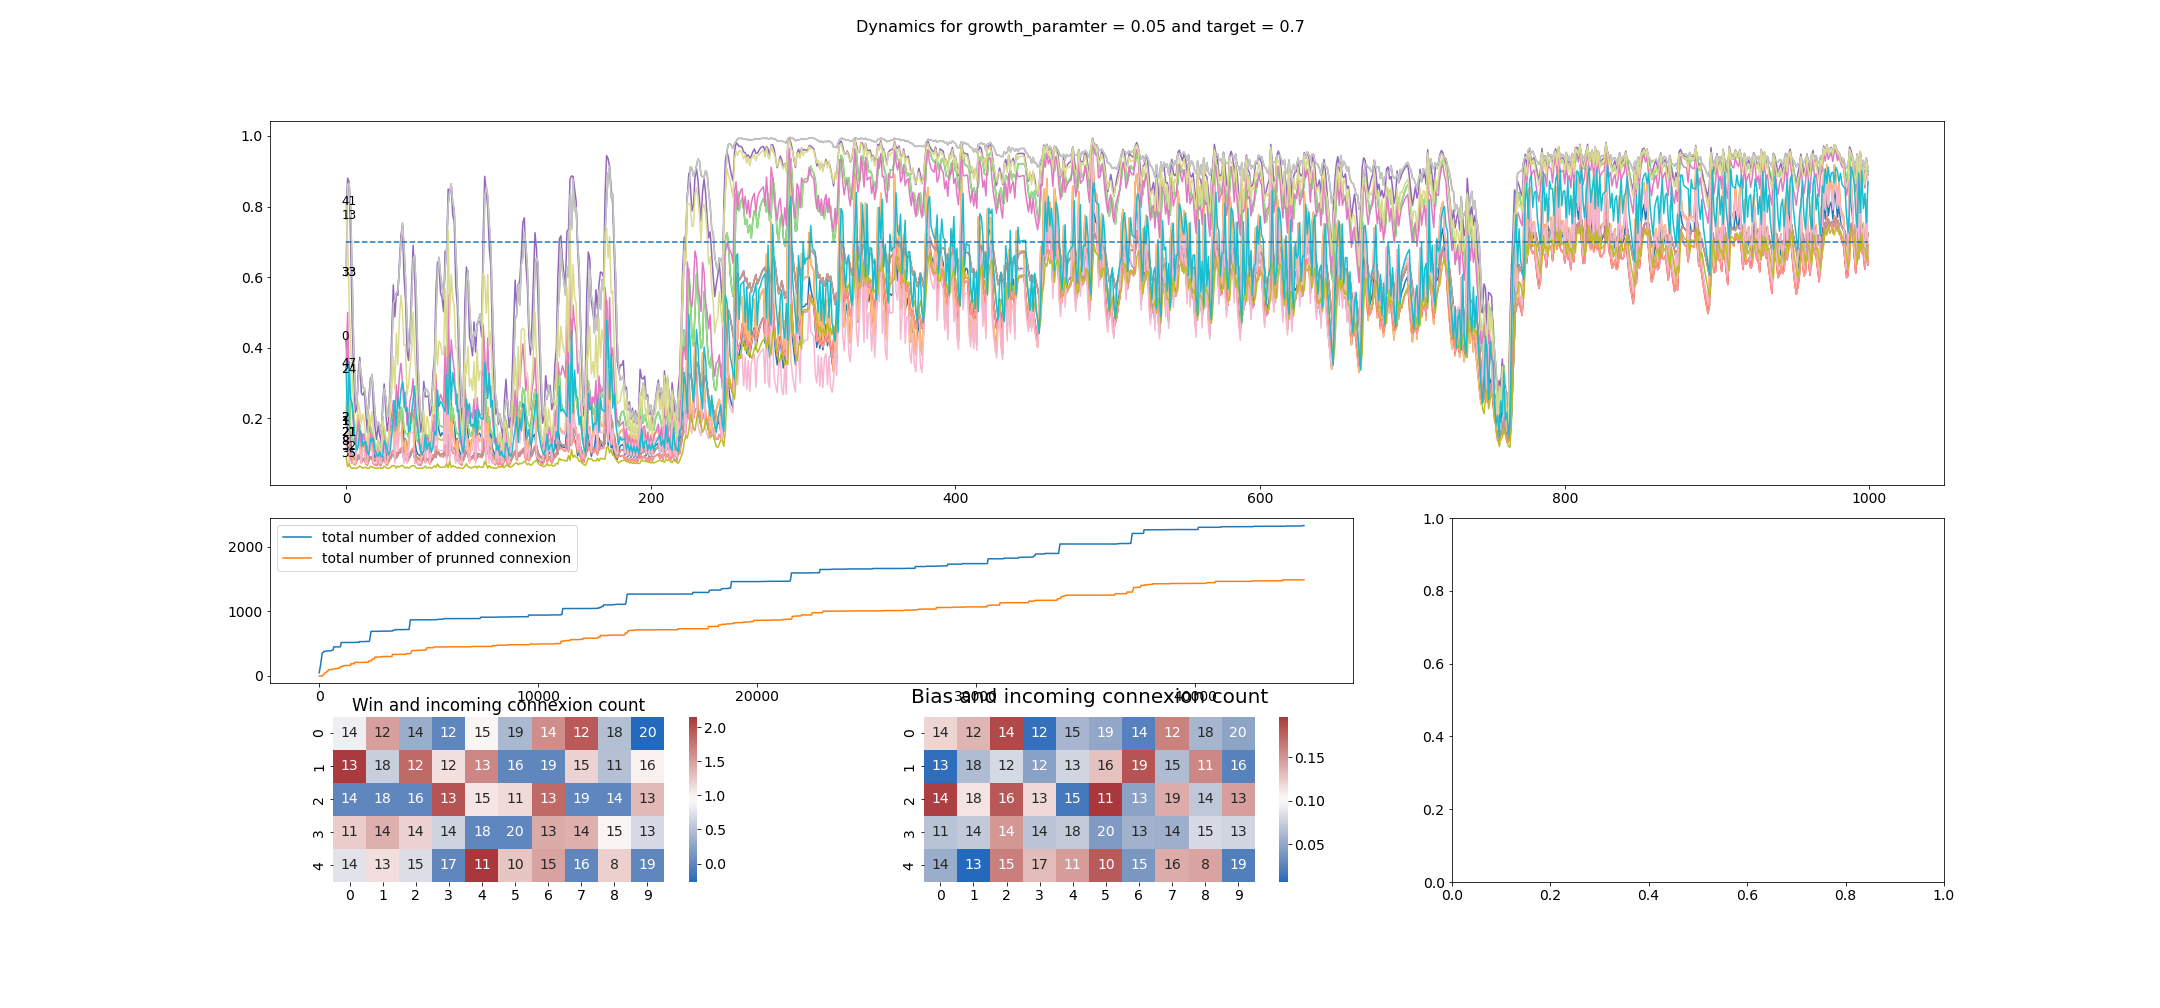

In [42]:
from math import copysign

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_paramter = {growth_parameter} and target = {target_activation_levels}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n, size=19)) #Size max is 19 because there is not enough colors
colors = color_palette("tab20")
NUMBER_OF_STEP_TO_WATCH = 1000
neurons_evolution = np.array(state_history)[:NUMBER_OF_STEP_TO_WATCH]
x =range(step*INCREMENT)[:NUMBER_OF_STEP_TO_WATCH]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_activation_levels]*NUMBER_OF_STEP_TO_WATCH, linestyle = "--", label="initial connectivity")
# plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.legend()

ax3 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)

ax4 = plt.subplot2grid((4, 3), (3, 0))
heatmap(Win.A.reshape(5,10), square=True, cmap=color_palette("vlag", as_cmap=True)
            , annot = incoming_connexion_count_history[-1].reshape(5,10), ax = ax4)
ax4.title.set_text(f'Win and incoming connexion count')

ax5 = plt.subplot2grid((4, 3), (3, 1))
heatmap(bias.reshape(5,10), square=True, cmap=color_palette("vlag", as_cmap=True)
            , annot = incoming_connexion_count_history[-1].reshape(5,10), ax = ax5)
ax5.text(0.5, 1.08, 'Bias and incoming connexion count',
         horizontalalignment='center',
         fontsize=20,
         transform = ax5.transAxes)

plt.show()

#### second set of parameters

In [37]:
# Parameters
minimum_calcium_concentration = np.ones(n)*0.1

# The parameters you want to see the influence

growth_parameter = 0.05
target_activation_levels=0.7

# Initialisation
W_with_activity_2 = W.copy()
U_train3 = U_train1
state = last_state
length = len(U_train3)
step_2=0
convergence_step_2 = 0

total_add = 0
total_prun = 0
add_2 = []
prun_2 = []

incoming_connexion_count_history_2 = []
state_history_2 = []
delta_z_history_2 = []


for i in range(INCREMENT*5):
    state = update_reservoir(W_with_activity, Win, U_train3[i], state, leaky_rate, bias, activation_function)
    state_history_2.append(state)
U_train3 = U_train3[INCREMENT*5:]


while total_add + total_prun < 3000 and length > 3000:

    incoming_connexion_count_history_2.append(count_incoming_connexions(W_with_activity_2))
    delta_z = compute_synaptic_change(state, target_activation_levels, growth_parameter, "linear", minimum_calcium_concentration)
    delta_z_history_2.append(delta_z)

    W_with_activity_2, nb_new_add, nb_new_prun = add_activity_connexion(W_with_activity_2, state, delta_z, VALUE)

    for i in range(INCREMENT):
        state = update_reservoir(W_with_activity_2, Win, U_train3[i], state, leaky_rate, bias, activation_function)
        state_history_2.append(state)
    U_train3 = U_train3[INCREMENT:]

    length = len(U_train3)
    total_add += nb_new_add
    total_prun += nb_new_prun
    add_2.append(total_add)
    prun_2.append(total_prun)
    if step_2 > 5 and convergence_step_2 == 0:
        mean_add = (add_2[-1]-add_2[-5])/2
        mean_prun = (prun_2[-1]-prun_2[-5])/2
        if prun_2[3] > add_2[3] and mean_add >= mean_prun: 
            convergence_step_2 = step
        if prun_2[3] < add_2[3] and mean_add <= mean_prun: 
            convergence_step_2 = step
            
    step_2 +=1
convergence_step_2

2249

In [38]:
plt.plot(np.arange(step_2)*INCREMENT, add_2, label="total number of added connexion")
plt.plot(np.arange(step_2)*INCREMENT, prun_2, label="total number of prunned connexion")
plt.legend()

##### Delta and number of connexion evolution

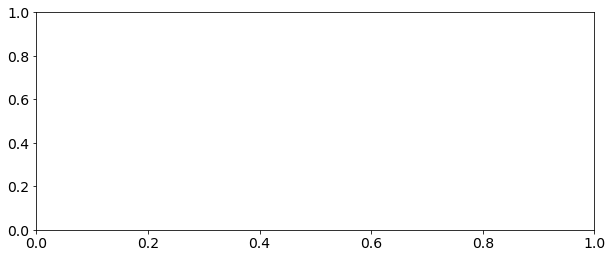

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))
max_count = int(np.max(incoming_connexion_count_history))
def init():
    heatmap(incoming_connexion_count_history[0].reshape(5,10), vmax=max_count, cmap=color_palette("YlOrBr", n_colors= max_count))
    
def animate(i):
    heatmap(incoming_connexion_count_history[i].reshape(5,10), cbar=False, cmap=color_palette("YlOrBr", n_colors=max_count))

    
anim2 = animation.FuncAnimation(fig, animate, init_func=init, frames=len(incoming_connexion_count_history), repeat = False, interval=1)
# writervideo = animation.FFMpegWriter(fps=1)
# anim.save("neurons_input_count.mp4", writer=writervideo)


KeyboardInterrupt: 

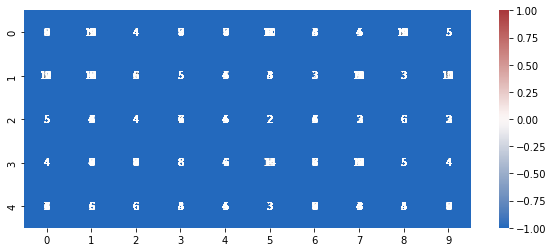

In [25]:

fig, ax = plt.subplots(figsize=(10, 4))

def init():
    heatmap(delta_z_history[0].reshape(5,10), cmap=color_palette("vlag", as_cmap=True),
               annot = incoming_connexion_count_history[0].reshape(5,10))
    
def animate(i):
    heatmap(delta_z_history[i].reshape(5,10), cbar=False, cmap=color_palette("vlag", as_cmap=True),
               annot = incoming_connexion_count_history[i].reshape(5,10))

    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(delta_z_history), repeat = False, interval=1)

from IPython.display import HTML
HTML(anim.to_jshtml())


# draw_heatmap_animation(incoming_connexion_count_history, len(delta_z_history), interval=1, file_to_save = "tets.mp4", fps = 10)

#### Richness

In [48]:
UD, frac = uncoupled_dynamics(W_with_activity, Win, bias, state, U_train1, leaky_rate, temp = 1000,A =0.9)
print("UD", UD, "for", frac)

# Spectral radius
eigen_values, eigen_vectors = sparse.linalg.eigs(W_with_activity, k=10, which="LM", maxiter=W.shape[0] * 20, tol = 0.1)
sr = max(abs(eigen_values))
print("spectral radius", sr)

UD 1 for 0.9066046174453253
spectral radius 1.3268480446674458


In [31]:
eigen_values

array([ 1.34642653+0.j        , -0.55321584+0.j        ,
       -0.49909625+0.13539842j, -0.49909625-0.13539842j,
       -0.33890831+0.41096604j, -0.33890831-0.41096604j,
       -0.35787759+0.3402921j , -0.35787759-0.3402921j ,
        0.14528309+0.47216228j,  0.14528309-0.47216228j])

#### Network analysis 

Papers : 
https://link.springer.com/article/10.1007/s11047-020-09823-1

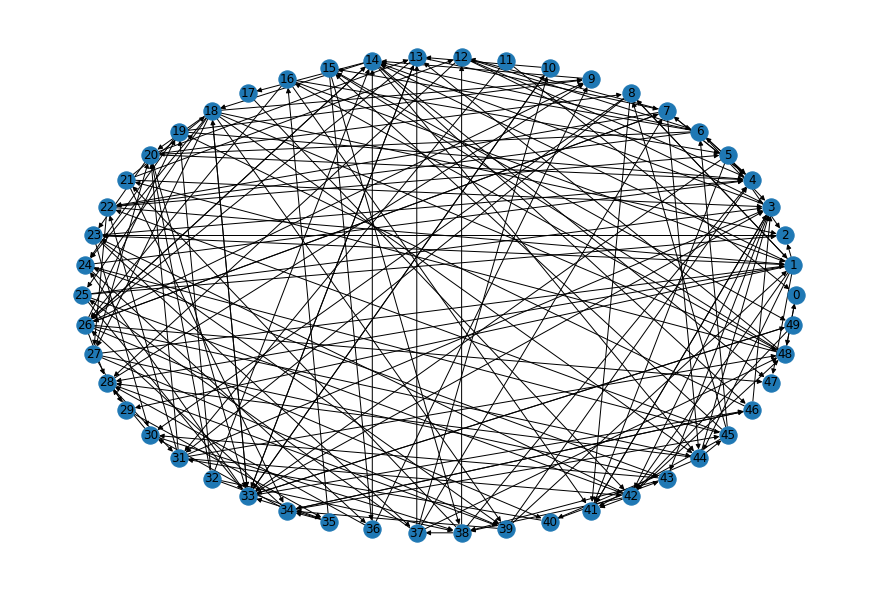

In [20]:
import networkx as nx

G = nx.from_scipy_sparse_array(W.T, create_using=nx.DiGraph)

G_with_activity = nx.from_scipy_sparse_array(W_with_activity.T, create_using=nx.DiGraph)

%matplotlib inline

plt.figure(figsize=(12,8))
nx.draw(G, pos=nx.circular_layout(G), with_labels = True)

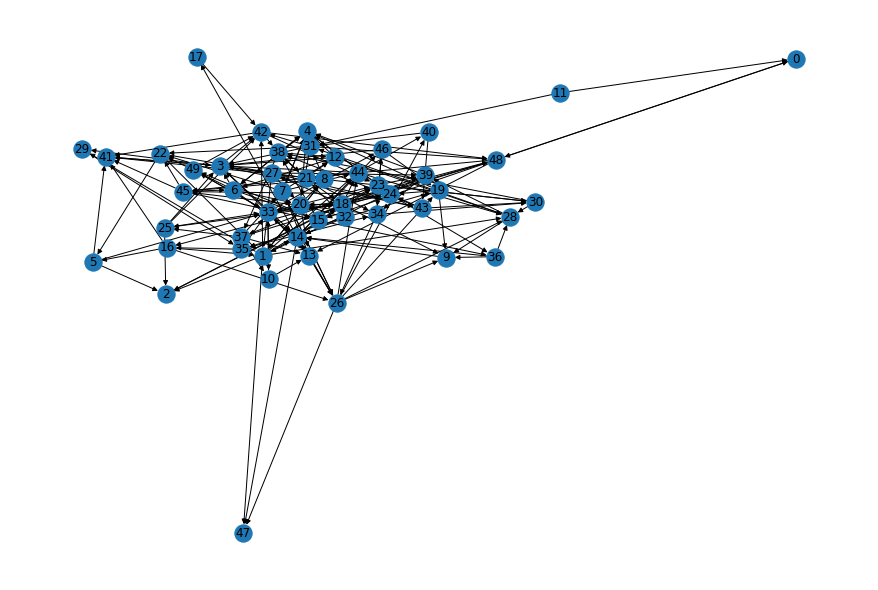

In [22]:
plt.figure(figsize=(12,8))
pos = nx.spring_layout(G, seed=10396953)
nx.draw(G, pos=pos, with_labels = True)

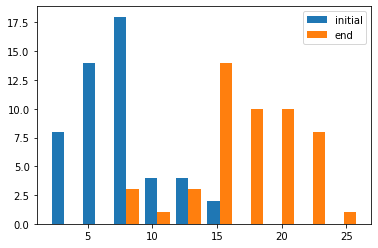

In [23]:
degrees = [val for (node, val) in G.degree()]
degrees_with_activity = [val for (node, val) in G_with_activity.degree()]

d1 = np.array(degrees)
d2 = np.array(degrees_with_activity)

plt.hist([d1, d2], label=['initial', 'end'])
plt.legend(loc='upper right')
plt.show()


In [ ]:
# get the local cluster coefficient dataframe
def get_eccentricity_df(graph):
    eccentricity_df = pd.DataFrame(sorted(nx.eccentricity(graph).items(), 
                                 key=lambda item: -item[1]), 
                      columns=["node", "eccentricity"])
    return eccentricity_df



# get sorted accentricty df
eccentricity_df = get_eccentricity_df(G_with_activity)
eccentricity_df["eccentricity"].plot.hist(figsize=(8,5), title="Eccentricity Distribution");



In [ ]:
def get_graph_info(graph):
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())

    if type(graph) == nx.classes.digraph.DiGraph:
        print("Connected components:", 
              list(nx.weakly_connected_components(graph)))
    else:
        print("Connected components:", list(nx.connected_components(graph)))
    print("Node degree:", dict(graph.degree()))


    
# get the local cluster coefficient dataframe
def get_local_cluster_coefficient(graph):
    LCC_df = pd.DataFrame(sorted(nx.clustering(graph).items(), 
                                 key=lambda item: -item[1]), 
                      columns=["node", "LCC"])
    return LCC_df



In [ ]:
from networkx.algorithms.community import louvain_partitions
import networkx.algorithms.community as nx_comm

# find communities
girvan_newman_communities = list(louvain_partitions(G))

# function create node color list for less than 7 communities
# when there are more than 6 colors, visualization can be confusing for human
def create_community_node_colors(graph, communities):
    number_of_colors = len(communities[0])
    colors = ["#EF9A9A", "#BA68C8", "#64B5F6", "#81C784",
              "#FFF176", "#BDBDBD"][:number_of_colors]
    node_colors = []
    
    # iterate each node in the graph and find which community it belongs to
    # if the current node is found at a specific community, add color to the 
    # node_colors list
    for node in graph:
        current_community_index = 0
        for community in communities:
            if node in community:
                node_colors.append(colors[current_community_index])
                break
            current_community_index += 1
    return node_colors

def visualize_communities(graph, communities):
    # create visualization
    node_colors = create_community_node_colors(graph, communities)
    modularity = round(nx_comm.modularity(graph, communities), 6)
    title = f"Community Visualization of {len(communities)} communities with modularity of {modularity}"
    pos = nx.spring_layout(graph, 
                           k=0.3, iterations=50,
                           SEED=2)

    plt.figure(1,figsize=(10,6)) 
    nx.draw(graph,
            pos = pos,
            node_size=1000,
            node_color=node_colors,
            with_labels=True,
            font_size = 20,
            font_color='black')
    plt.title(title)
    plt.show() 

visualize_communities(G, girvan_newman_communities[0])



In [ ]:
%matplotlib inline

from math import copysign

plt.figure(figsize=(18, 6))
random_neurons_indices =  np.sort(np.random.randint(n, size=19)) #Size max is 19 because there is not enough colors
# non_zeros_indices = np.flatnonzero(Wout)[:19]
colors = color_palette("tab20")

temp = 400
x =range(temp)
neurons_evolution = np.array(state_history)[:temp]
j = 0
for i in random_neurons_indices:
    plt.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    plt.plot(0, neurons_evolution[0, i], marker='o', color=colors[j],  alpha=0.5)
    plt.text(-3, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1

# plt.plot(np.arange(0, temp), y_pred1[-temp:], label="Training objective", color=colors[-1])

plt.legend(fontsize=16, loc="right")

In [ ]:
show_matrice(W_with_activity)

In [ ]:
show_matrice(W)